In [1]:
]activate ../../../

  Activating project at `~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode`


In [2]:
using Revise
includet("./base.jl")

using StatsBase
using UnPack
# using DimensionalData
# includet("../../../scripts/dimdata_util.jl")

In [3]:
using GLMakie
using CairoMakie

# Setup

In [206]:
function clamp_for_log(xx)
    clamp.(xx, max(minimum(xx), eps()), Inf)
end

clamp_for_log (generic function with 1 method)

In [207]:
function make_quality_summary(f)
    display(countmap(f["retcodes"]))

    logKs = f["logKs"]
    ls = f["ls"]
    leak_xs = LeakageScale.ltox.(ls)

    ext_ls = extrema(ls)
    exticks = LeakageScale.exticks(range(1 - ext_ls[2], 1 - ext_ls[1], 7))
    
    fig = Figure(;
        size=(1000, 400)
    )

    ax1 = make_hm_ax(fig[1,1];
        yticks=exticks,
        title="Reached final time"
    )
    hm1 = heatmap!(ax1, 10 .^ logKs, leak_xs, f["final_T"];
        colorscale=log10
    )
    Colorbar(fig[1,2], hm1)

    maxresids = map(zip(f["params"], f["final_states"])) do (ps, fs)
        maximum(abs, uninplace(smmicrmfunc!)(fs, ps))
    end;
    ax2 = make_hm_ax(fig[1,3];
        yticks=exticks,
        title="Maximal absolute residuals"
    )
    hm2 = heatmap!(ax2, 10 .^ logKs, leak_xs, clamp_for_log(maxresids);
        colorscale=log10
    )
    Colorbar(fig[1,4], hm2)

    fig
end

make_quality_summary (generic function with 1 method)

In [212]:
function draw_fr_ext_line!(ax, ls;
    m=1.,
    c=1.,
    kwargs...
)
    r = 1.
    line_Ks = map(ls) do l
        if l > 0.5
            4 * l * m * r / c
        else
            m * r / (c * (1 - l))
        end
    end
    
    lines!(ax, line_Ks, LeakageScale.ltox.(ls);
        kwargs...
    )

    ax
end
function draw_fr_instab_line!(ax, ls;
    m=1.,
    c=1.,
    kwargs...
)
    r = 1.
    line_Ks = map(ls) do l
        if l > 0.5
            m * r / (c * (1 - l))
        else
            missing
        end
    end
    
    lines!(ax, line_Ks, LeakageScale.ltox.(ls);
        kwargs...
    )

    ax
end

draw_fr_instab_line! (generic function with 1 method)

In [211]:
function make_hm_ax(args...; kwargs...)
    Axis(args...;
        # yticks=exticks,
        ylabel=L"\epsilon",
        xlabel=L"K",
        xscale=log10,
        kwargs...
    )
end

make_hm_ax (generic function with 1 method)

# Run no-space

In [ ]:
@time nospace_results = run_Kl_nospace(f;
    maxtime=10,
    maxiters=10000000,
    tol=1000*eps(),
    # solver=QNDF(),
)

nsfss = nospace_results.final_states
nsfTs = nospace_results.final_Ts

countmap(nospace_results.retcodes)

Progress:   2%|█                                        |  ETA: 0:07:42

In [ ]:
jldsave("./v2_2/nospace_base_trbdf2.jld2"; logKs, ls, nospace_results)

### Debugging

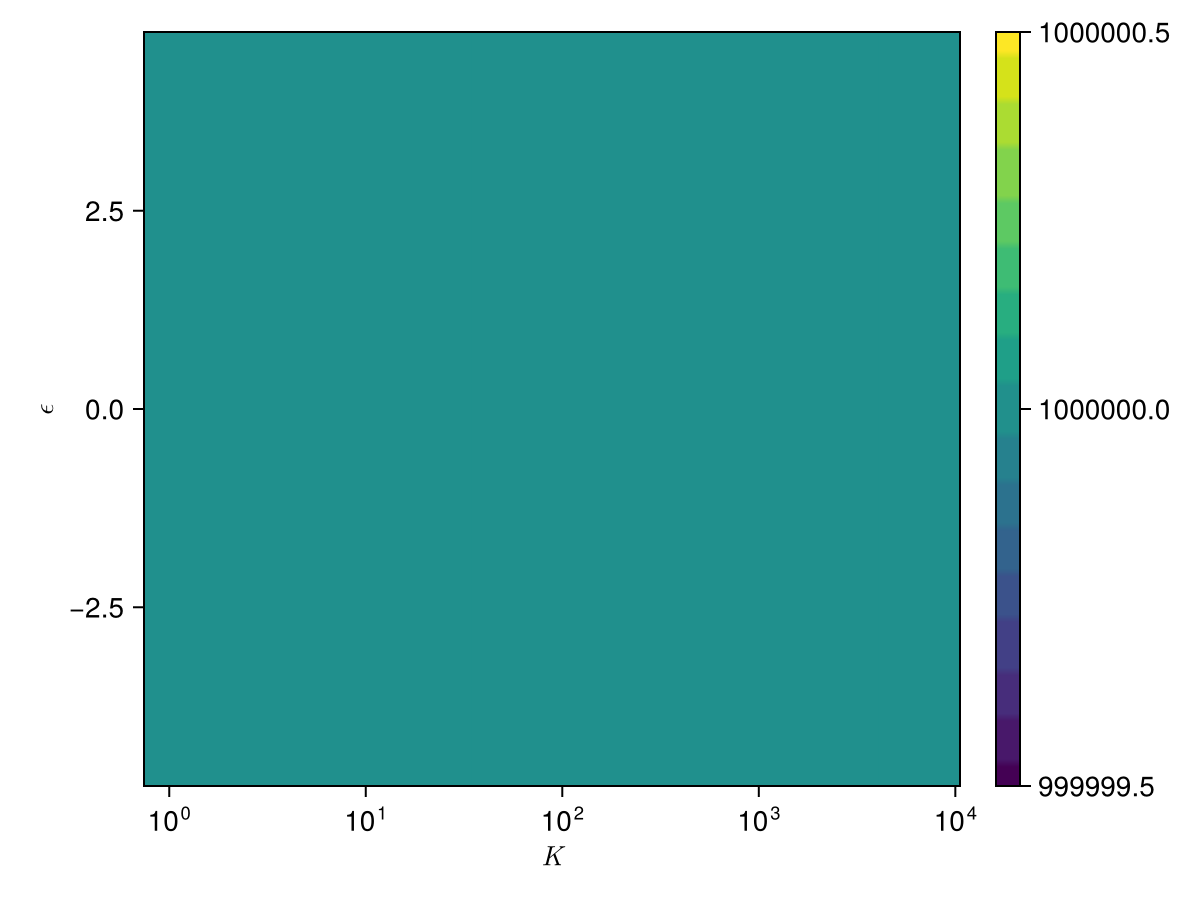

In [76]:
fig = Figure()
ax = make_hm_ax(fig[1,1])
hm = heatmap!(ax, 10 .^ logKs, leak_xs, nospace_results.final_Ts;
    # colorscale=log10
)
# hm = heatmap!(ax, 10 .^ logKs, leak_xs, Int.(nospace_results.retcodes); colormap=Categorical(:viridis))
Colorbar(fig[1,2], hm)
fig

In [81]:
mmp = MMParams(;
    K=10^1.9,
    l=0.99,
    m=10.,
    c=1.,
    k=0.0,
    d=1.0,
)
ps = mmp_to_mmicrm(mmp)
p = make_mmicrm_problem(ps, copy([100., 0., 0.]), T)

tol = 1000 * eps()
@time s = solve(p, TRBDF2();
    abstol=tol,
    reltol=tol,
    callback=make_timer_callback(10),
);

  0.044416 seconds (72.75 k allocations: 6.429 MiB)


In [82]:
f = plot_mmicrm_sol(s)
display(GLMakie.Screen(), f)

GLMakie.Screen(...)

# Load data

## Base

In [532]:
# Load with space
f = jldopen("./v2_2/v2main_highN0_base.jld2")
logKs = f["logKs"]
ls = f["ls"]
leak_xs = LeakageScale.ltox.(ls)
T = f["T"]
fss = f["final_states"]
fTs = f["final_T"]

@show countmap(f["retcodes"])
@show T
@show extrema(fTs);

# Load no-space
nsf = jldopen("./v2_2/nospace_base_trbdf2.jld2")
nospace_results = nsf["nospace_results"];

@show countmap(nospace_results.retcodes)

countmap(f["retcodes"]) = Dict{SciMLBase.ReturnCode.T, Int64}(SciMLBase.ReturnCode.Success => 2400)
T = 1.0e6
extrema(fTs) = (1.0e6, 1.0e6)
countmap(nospace_results.retcodes) = Dict{SciMLBase.ReturnCode.T, Int64}(SciMLBase.ReturnCode.Success => 2400)


Dict{SciMLBase.ReturnCode.T, Int64} with 1 entry:
  Success => 2400

Dict{SciMLBase.ReturnCode.T, Int64} with 1 entry:
  Success => 2400

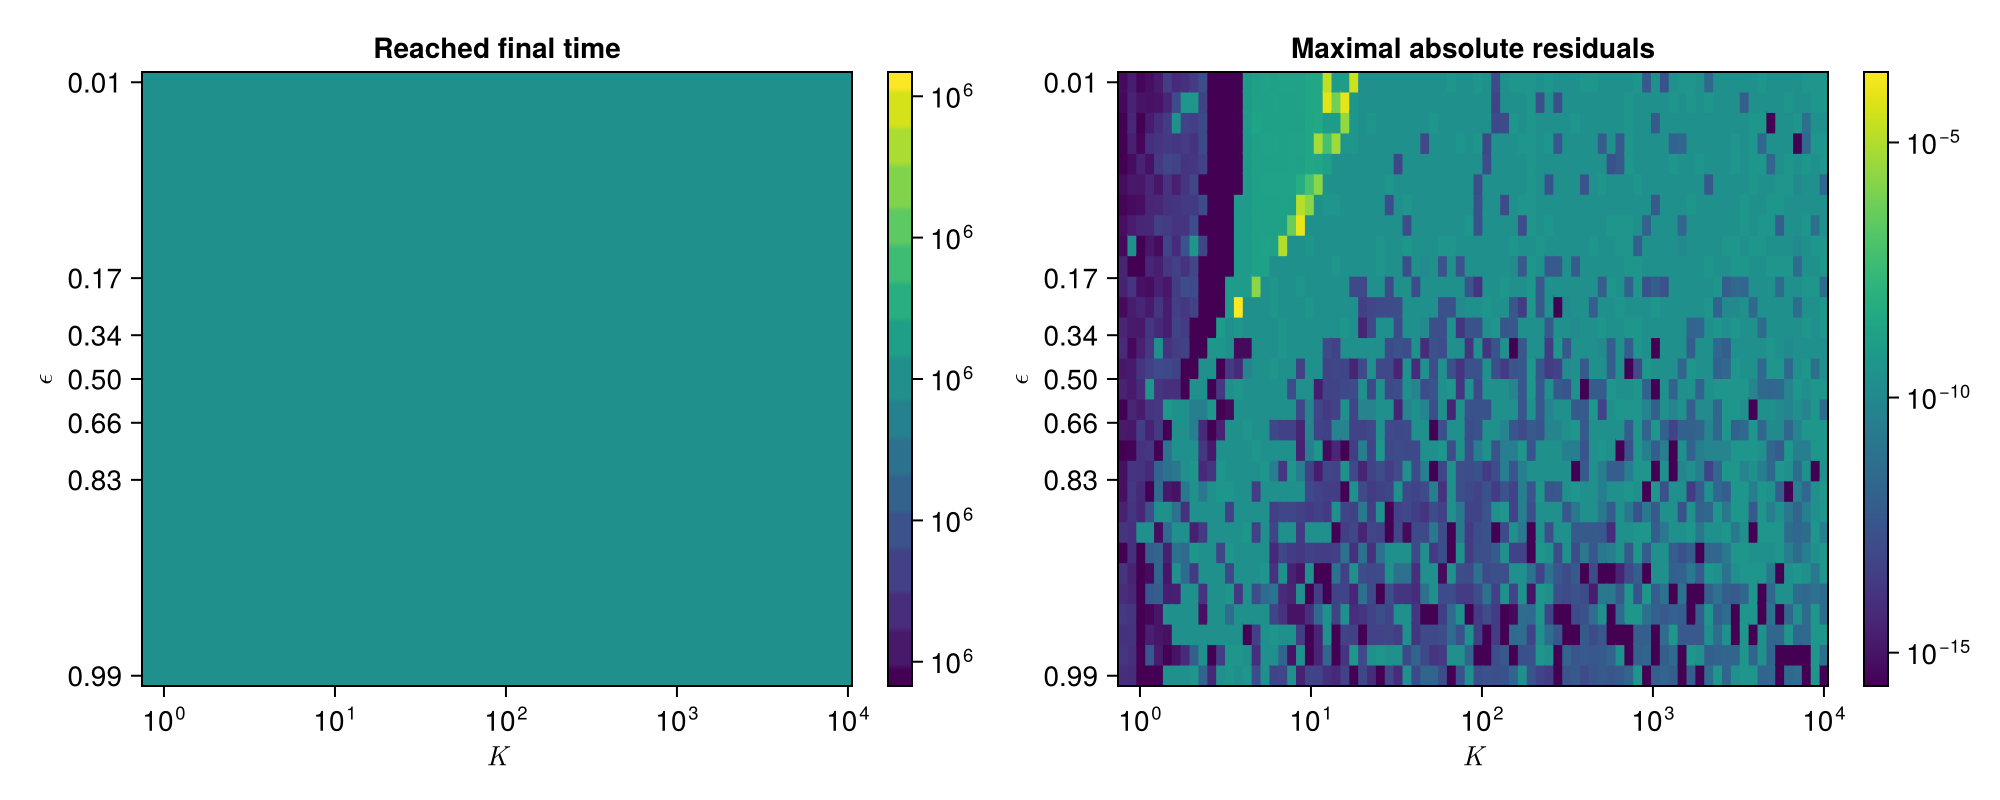

In [533]:
make_quality_summary(f)

## Second v2 - m=10, DR=0.1, logit ls

In [514]:
# Load with space
f = jldopen("./v2_2/v2main_highN0_largem_lowDR2.jld2")
logKs = f["logKs"]
ls = f["ls"]
leak_xs = LeakageScale.ltox.(ls)
T = f["T"]
fss = f["final_states"]
fTs = f["final_T"]

ext_ls = extrema(ls)
exticks = LeakageScale.exticks(range(1 - ext_ls[2], 1 - ext_ls[1], 7))

@show countmap(f["retcodes"])
@show T
@show extrema(fTs);

# Load no-space
nsf = jldopen("./v2_2/nospace_largem_lowDR2_trbdf2.jld2")
nospace_results = nsf["nospace_results"];

@show countmap(nospace_results.retcodes);

countmap(f["retcodes"]) = Dict{SciMLBase.ReturnCode.T, Int64}(SciMLBase.ReturnCode.Success => 2386, SciMLBase.ReturnCode.MaxTime => 14)
T = 1.0e6
extrema(fTs) = (453417.6802396609, 1.0e6)
countmap(nospace_results.retcodes) = Dict{SciMLBase.ReturnCode.T, Int64}(SciMLBase.ReturnCode.Success => 2400)


Dict{SciMLBase.ReturnCode.T, Int64} with 2 entries:
  Success => 2386
  MaxTime => 14

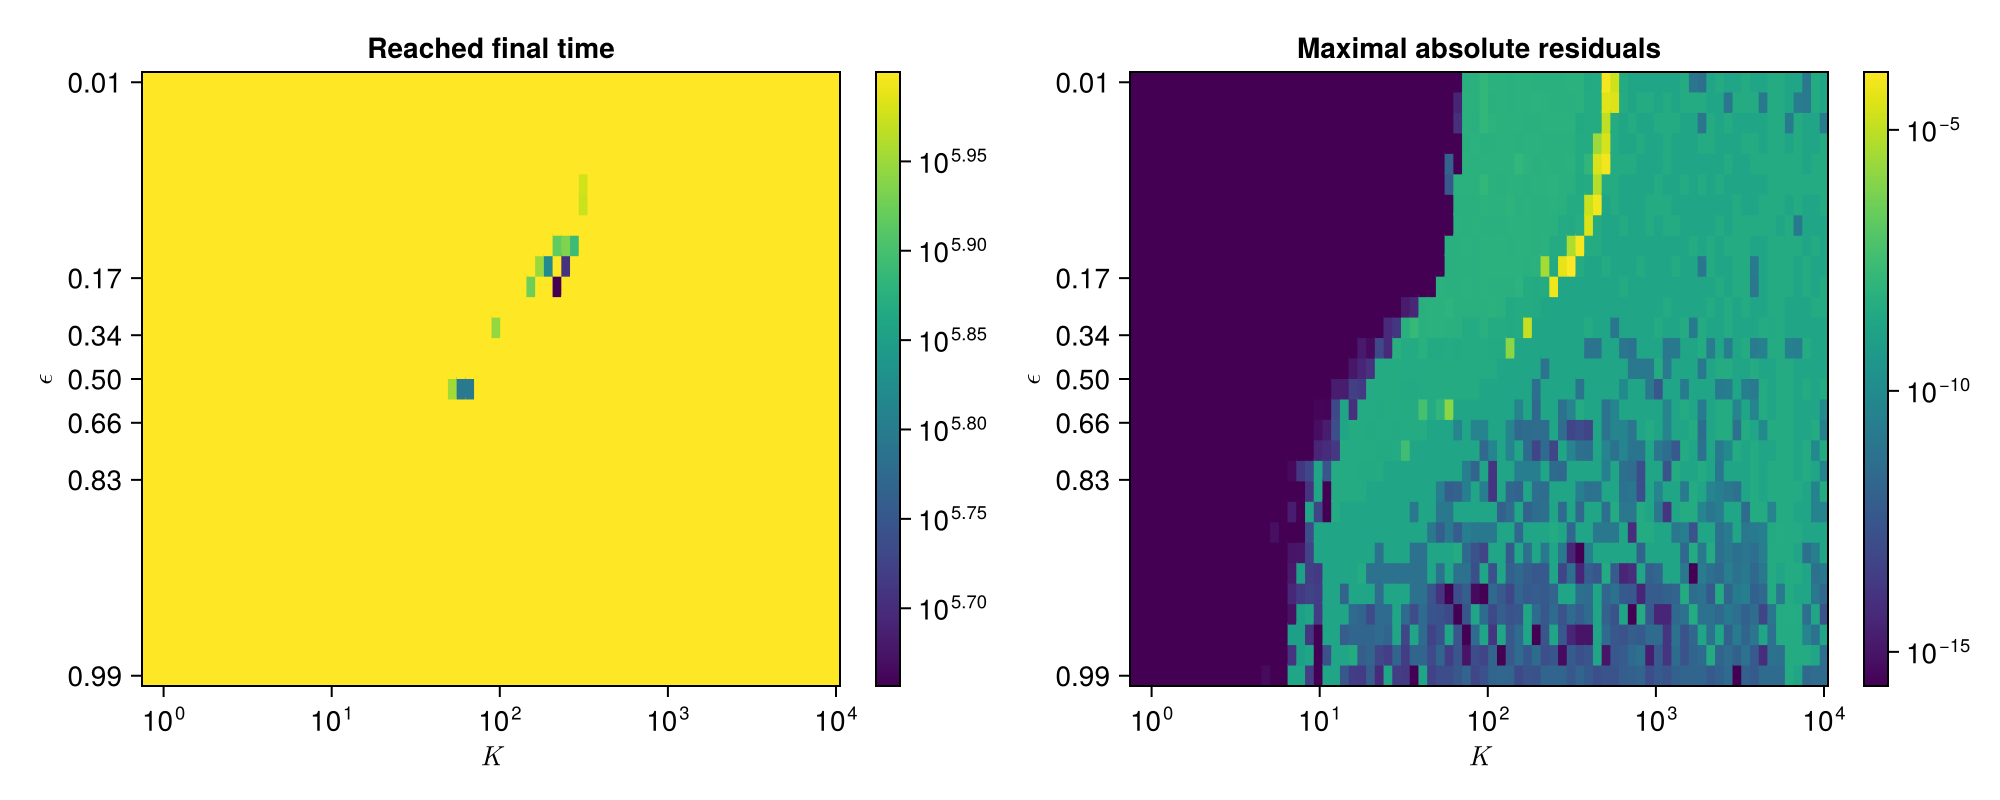

In [515]:
make_quality_summary(f)

### Some runs, in a particular region seem to be running into max time
however when inspecting them this does not seem to be particularly interesting, they look qualitatively similar to others and seem to be very close to steady states already

In [50]:
xx = DimArray(fss, (; logKs, ls));
yy = DimArray(fTs, (; logKs, ls));

yy[ii...] = 662939.0549164473


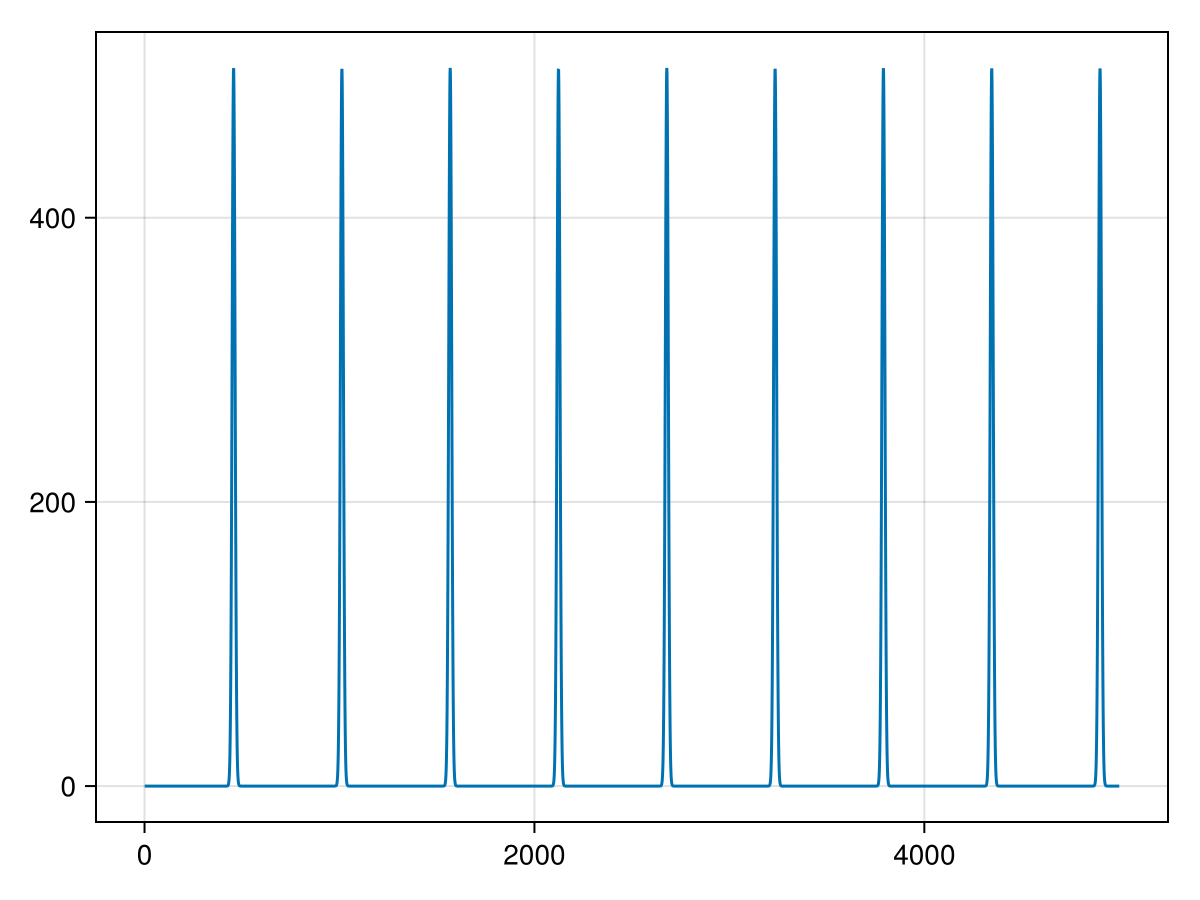

In [51]:
ii = (Near(2.3), Near(1-0.17))
@show yy[ii...]
lines(xx[ii...][1,:])

# Identifying spatial structure in PDE sol
Focus just on N as the others will reflect that

## Basic stats (mean and std)

In [253]:
fs_N = map(fss) do fs
    fs[1,:]
end;

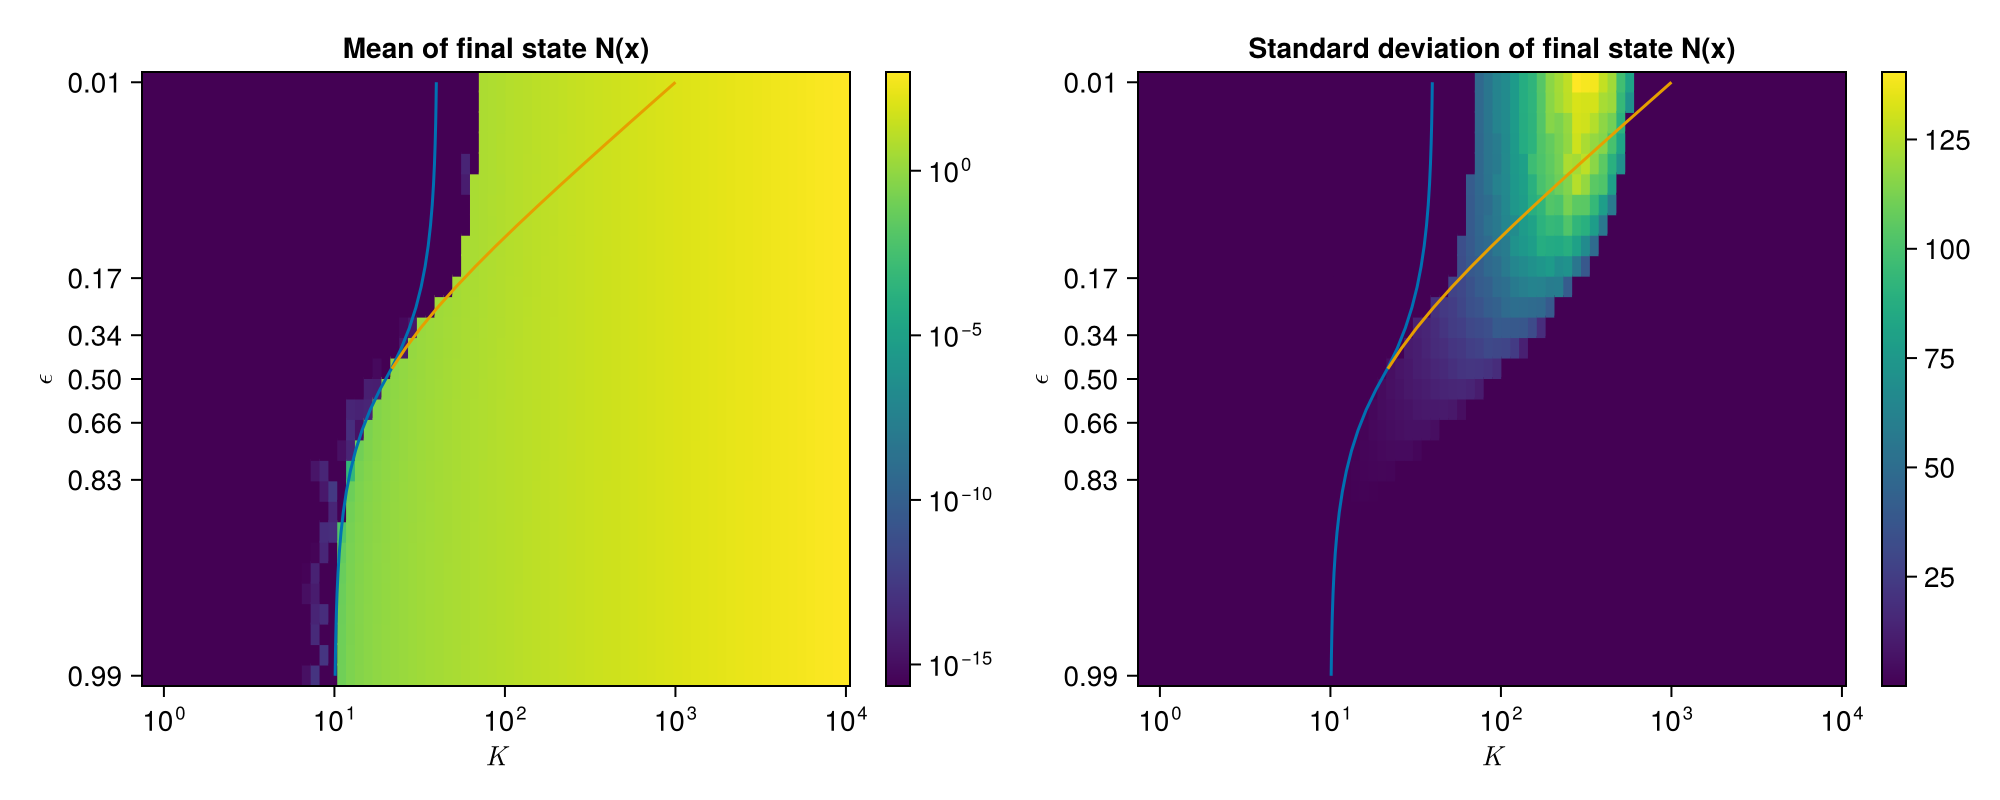

In [256]:
fig = Figure(; size=(1000, 400))
ax1 = make_hm_ax(fig[1,1];
    title="Mean of final state N(x)",
    yticks=exticks,
)
hm1 = heatmap!(ax1, 10 .^ logKs, leak_xs, clamp_for_log(mean.(fs_N));
    colorscale=log10
)
Colorbar(fig[1,2], hm1)
ax2 = make_hm_ax(fig[1,3];
    title="Standard deviation of final state N(x)",
    yticks=exticks,
)
hm2 = heatmap!(ax2, 10 .^ logKs, leak_xs, clamp_for_log(std.(fs_N));
    # colorscale=log10
)

for ax in [ax1, ax2]
    draw_fr_ext_line!(ax, ls; m=f["m"])
    draw_fr_instab_line!(ax, ls; m=f["m"])
end

Colorbar(fig[1,4], hm2)
fig

## Extracting peaks

In [534]:
using Peaks

In [535]:
full_peaks = map(fss) do fs
    all_pks = findmaxima(fs[1,:])
    peakproms(all_pks; min=0.1)
end;
numpeaks = map(full_peaks) do pks length(pks.indices) end;
avg_pkh = map(full_peaks) do pks
    mean(pks.heights)
end;
dx = f["L"] / (f["sN"] + 1)
avg_pkw = map(full_peaks) do pks
    if length(pks.indices) > 0
        mean(peakwidths(pks).widths) * dx
    else
        missing
    end
end;
avg_pkp = map(full_peaks) do pks
    if length(pks.indices) > 0
        mean(peakproms(pks).proms)
    else
        missing
    end
end;
avg_pksp = map(full_peaks) do pks
    if length(pks.indices) > 1
        mean(pks.indices[2:end] .- pks.indices[1:end-1]) * dx
    else
        missing
    end
end;

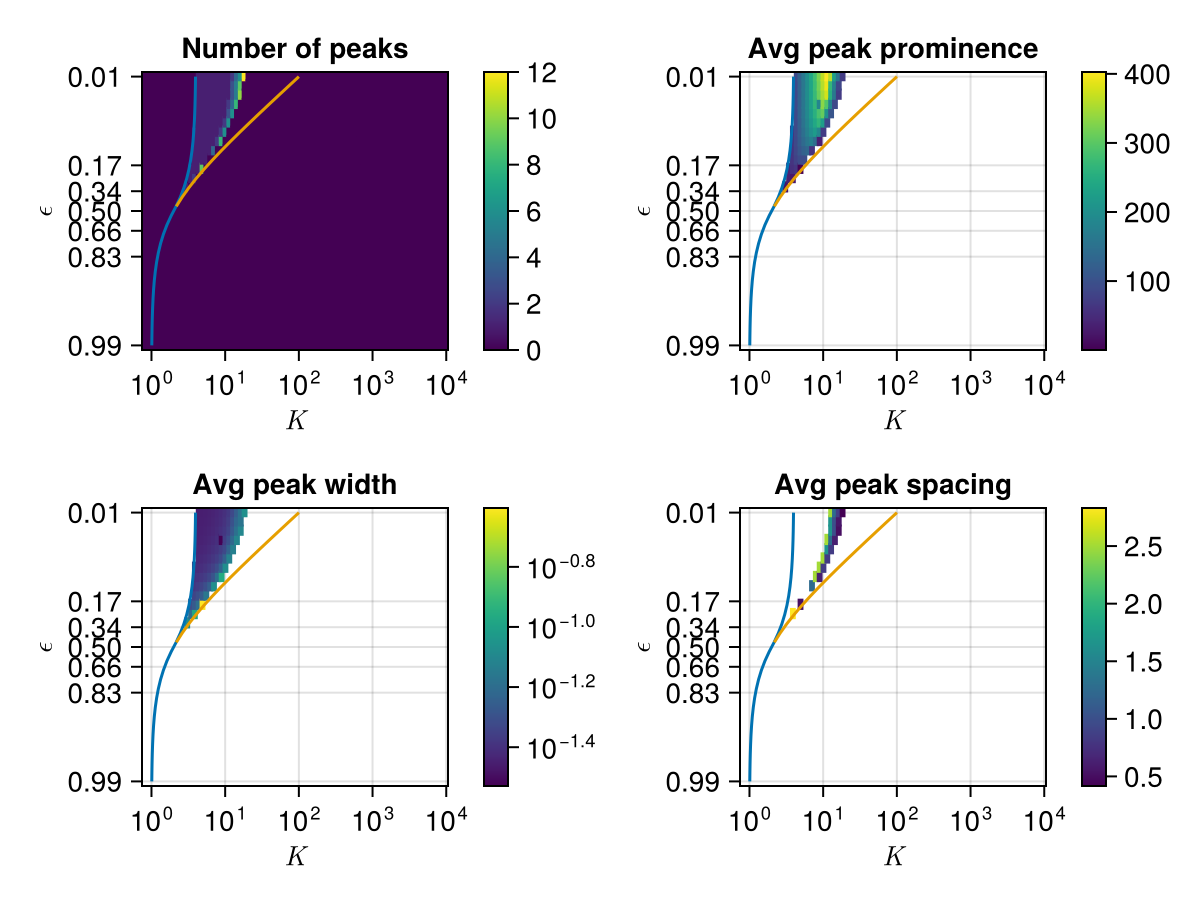

In [536]:
fig = Figure()
gl1 = GridLayout(fig[1,1])
ax1 = make_hm_ax(gl1[1,1];
    yticks=exticks,
    title="Number of peaks"
)
hm1 = heatmap!(ax1, 10 .^ logKs, leak_xs, numpeaks;
    # colorscale=log10,
)
Colorbar(gl1[1,2], hm1)

gl2 = GridLayout(fig[1,2])
ax2 = make_hm_ax(gl2[1,1];
    yticks=exticks,
    title="Avg peak prominence"
)
hm2 = heatmap!(ax2, 10 .^ logKs, leak_xs, avg_pkp;
    # colorscale=log10,
)
Colorbar(gl2[1,2], hm2)

gl3 = GridLayout(fig[2,1])
ax3 = make_hm_ax(gl3[1,1];
    yticks=exticks,
    title="Avg peak width"
)
hm3 = heatmap!(ax3, 10 .^ logKs, leak_xs, avg_pkw;
    colorscale=log10,
)
Colorbar(gl3[1,2], hm3)

gl4 = GridLayout(fig[2,2])
ax4 = make_hm_ax(gl4[1,1];
    yticks=exticks,
    title="Avg peak spacing"
)
hm4 = heatmap!(ax4, 10 .^ logKs, leak_xs, avg_pksp;
    # colorscale=log10,
)
Colorbar(gl4[1,2], hm4)

for ax in [ax1, ax2, ax3, ax4]
    draw_fr_ext_line!(ax, ls; m=f["m"])
    draw_fr_instab_line!(ax, ls; m=f["m"])
end

draw_fr_ext_line!(ax, ls; m=f["m"])
draw_fr_instab_line!(ax, ls; m=f["m"])

Makie.save("./peaks_summary.pdf", fig)

fig

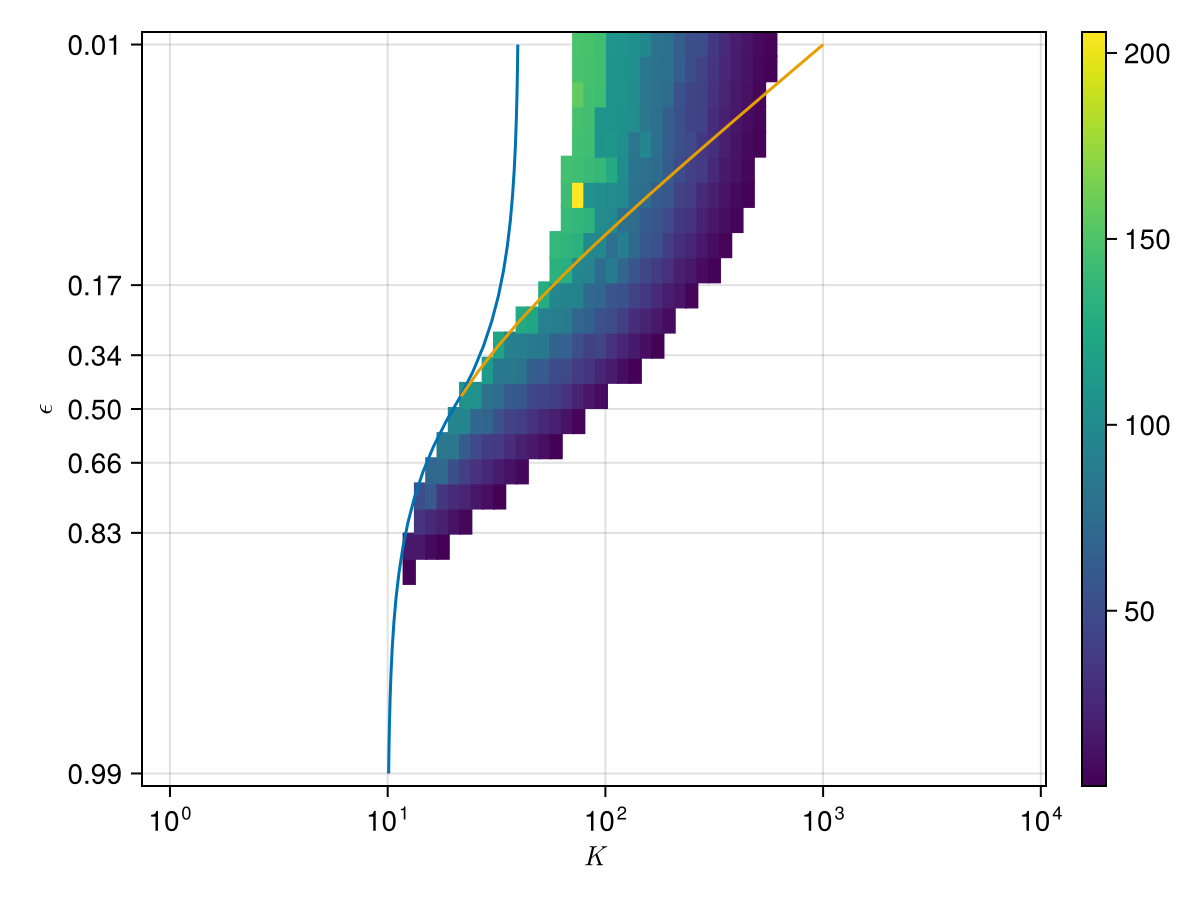

In [528]:
fig = Figure()
ax = make_hm_ax(fig[1,1];
    yticks=exticks,
)
hm = heatmap!(ax, 10 .^ logKs, leak_xs, avg_pksp ./ avg_pkw;
    # colorscale=log10,
)
Colorbar(fig[1,2], hm)

draw_fr_ext_line!(ax, ls; m=f["m"])
draw_fr_instab_line!(ax, ls; m=f["m"])

fig

### Testing

In [518]:
xx = DimArray(fs_N, (; logKs, ls));

In [519]:
_, maxpkw_ci = findmax(avg_pkw) do w
    if ismissing(w)
        -Inf
    else
        w
    end
end

(0.13632142459157937, CartesianIndex(24, 9))

In [523]:
mean(pks.indices[2:end] .- pks.indices[1:end-1])

555.625

extrema(ss) = (0.0005698185068506904, 0.4256813031666921)
length(pks.indices) = 9
length(pks.indices) = 9
mean(pks.widths) = 136.34868887649768


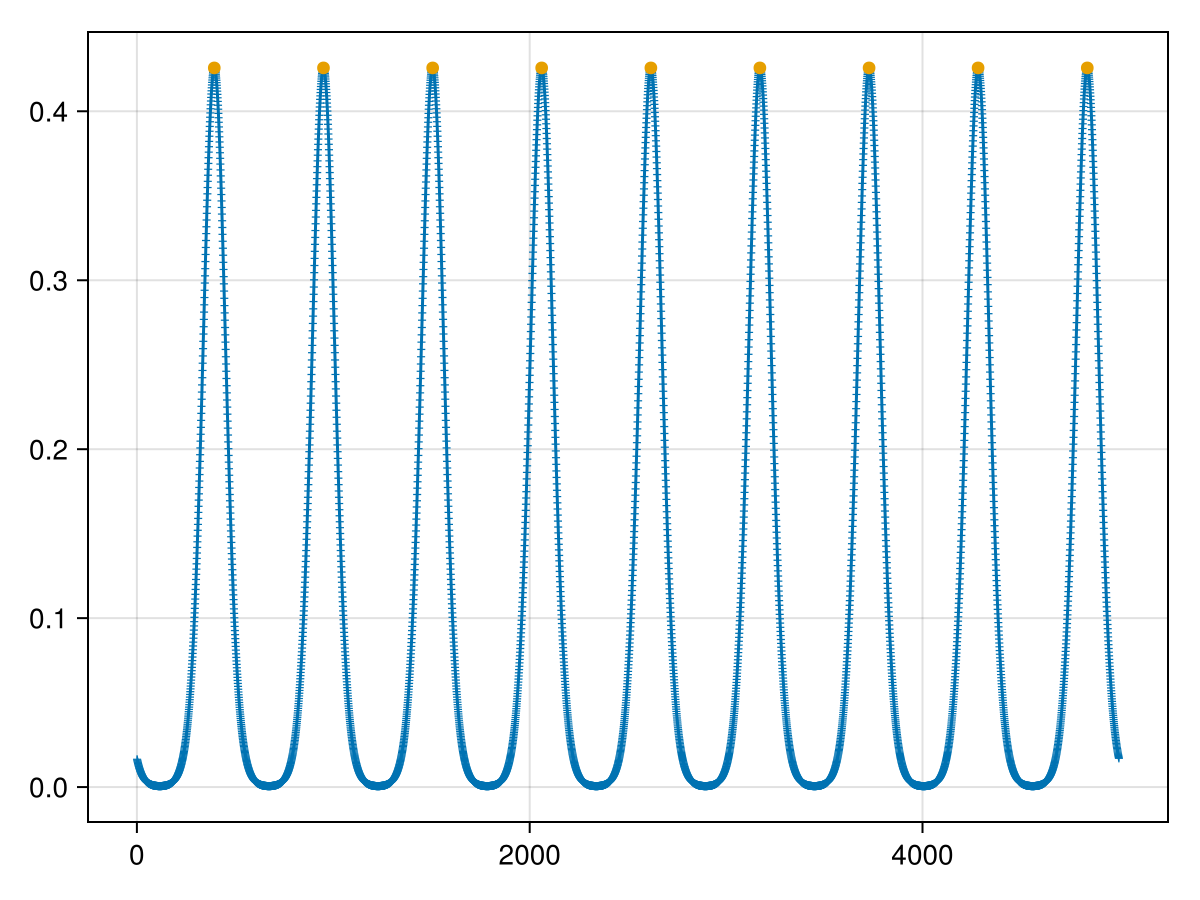

In [520]:
# ss = xx[Near(1.7),Near(0.4)];
ss = xx[maxpkw_ci];
@show extrema(ss)
# scatterlines(ss; marker='+')

pks = findpeaks(ss);
@show length(pks.indices)
# pks = peakheights(pks; min=0.1);
# @show length(pks.indices)
pks = peakproms(pks; min=0.1);
@show length(pks.indices)
pks = peakwidths(pks;
    # min=10
);
# @show length(pks.indices)

@show mean(pks.widths)

fap = scatterlines(1:length(ss), ss; marker='+')
scatter!(fap.axis, pks.indices, ss[pks.indices]; color=Cycled(2))
fap

In [505]:
display(GLMakie.Screen(), fap)

GLMakie.Screen(...)

# Comparing avg final state N

In [240]:
wsNs = clamp_for_log(map(fss) do fs
        mean(fs[1,:])
    end
)
nsNs = clamp_for_log(getindex.(nospace_results.final_states, 1))
dNs = wsNs .- nsNs
ext = extrema(vcat(wsNs, nsNs))

(2.220446049250313e-16, 9998.989999989999)

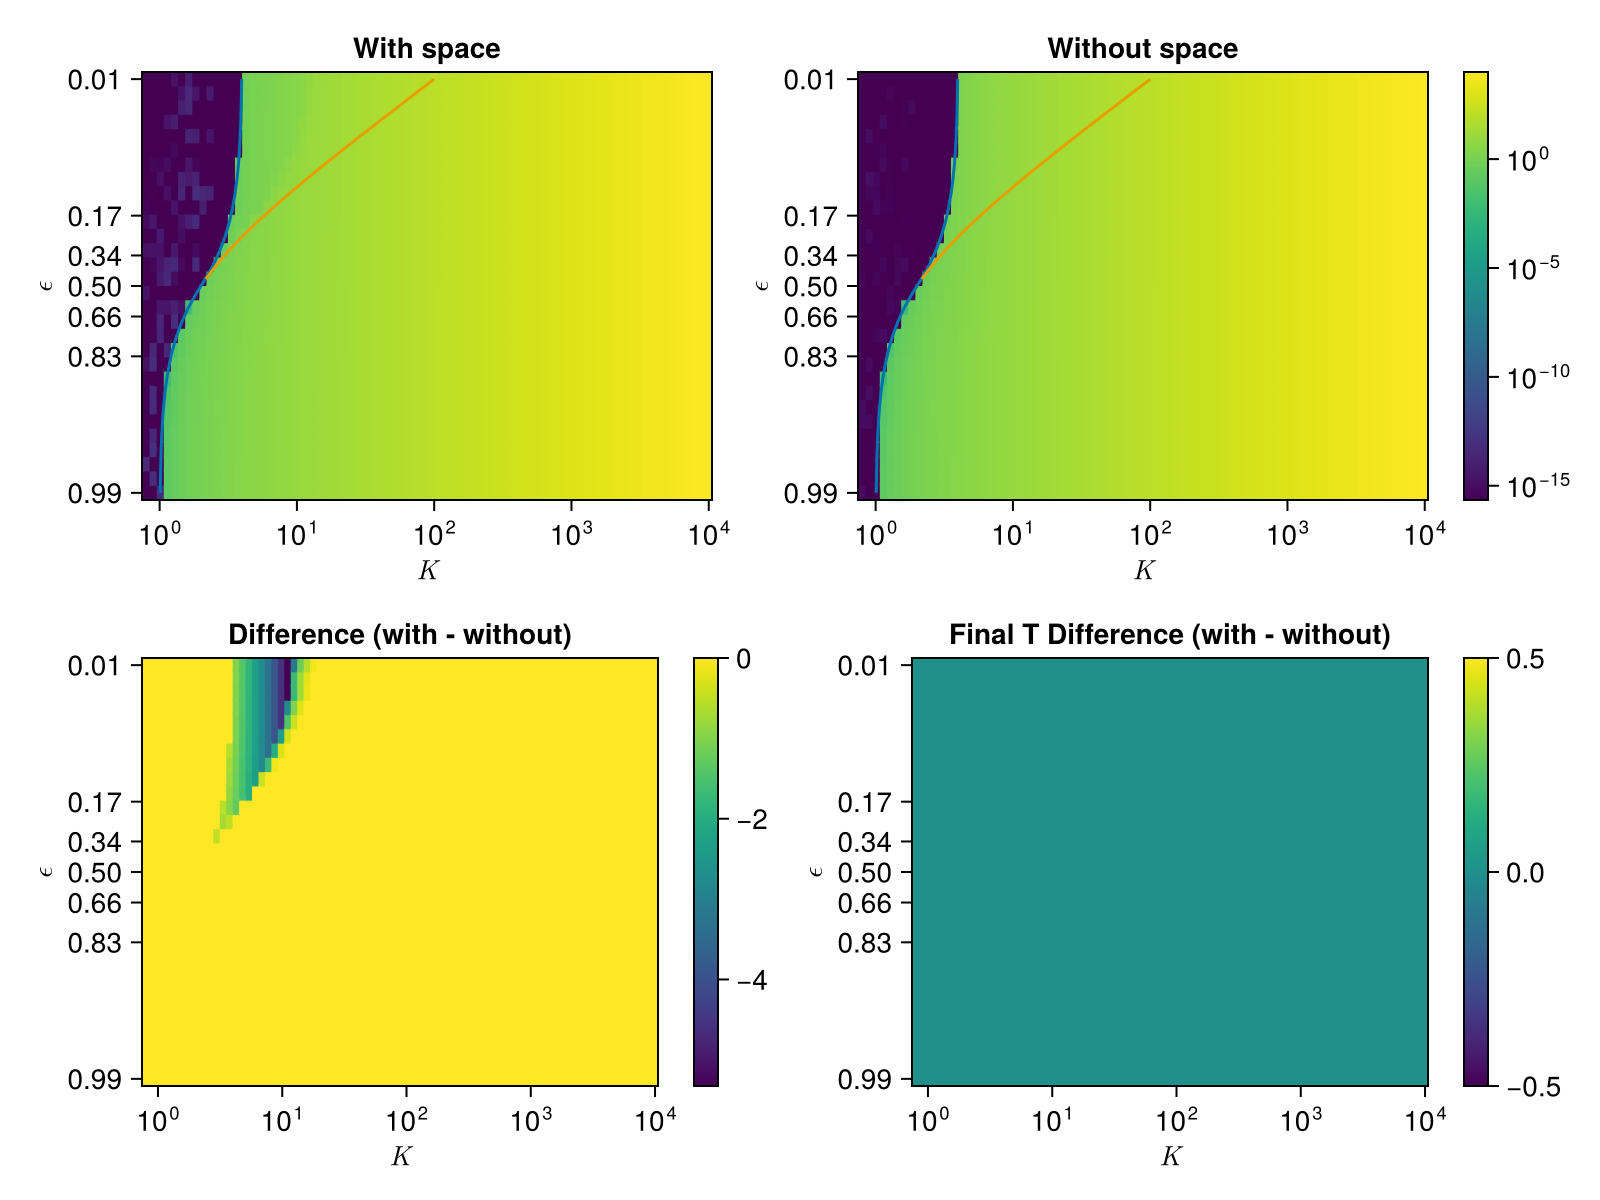

In [241]:
fig = Figure(;
    size=(800, 600),
)

gl_sbs = GridLayout(fig[1,1:2])

ax1 = make_hm_ax(gl_sbs[1,1]; title="With space", yticks=exticks)
ax2 = make_hm_ax(gl_sbs[1,2]; title="Without space", yticks=exticks)

hm1 = heatmap!(ax1, 10 .^ logKs, leak_xs, wsNs;
    colorscale=log10,
    colorrange=ext
)
hm2 = heatmap!(ax2, 10 .^ logKs, leak_xs, nsNs;
    colorscale=log10,
    colorrange=ext
)

for ax in [ax1, ax2]
    draw_fr_ext_line!(ax, ls; m=f["m"])
    draw_fr_instab_line!(ax, ls; m=f["m"])
end

Colorbar(gl_sbs[1,3], hm1)

gl_dN = GridLayout(fig[2,1])

ax3 = make_hm_ax(gl_dN[1,1]; title="Difference (with - without)", yticks=exticks)
hm3 = heatmap!(ax3, 10 .^ logKs, leak_xs, dNs;
)
Colorbar(gl_dN[1,2], hm3)

gl_dT = GridLayout(fig[2,2])
ax4 = make_hm_ax(gl_dT[1,1]; title="Final T Difference (with - without)", yticks=exticks)
hm4 = heatmap!(ax4, 10 .^ logKs, leak_xs, fTs .- nospace_results.final_Ts;
)
Colorbar(gl_dT[1,2], hm4)

Makie.save("./final_avg_N_summary.pdf", fig)

fig

# Basics

# Running a single system

In [264]:
L = 5 # system size in non-dim units
sN = 5000 # number of spatial points
epsilon = 1e-5 # initial condition noise amplitude

dx = L / (sN + 1)
u0 = clamp.(reduce(hcat, [[100.0, 0.0, 0.0] .+ epsilon .* randn(3) for _ in 1:sN]), 0.0, Inf)

mmp = MMParams(;
    K=10. ^ 2.3,
    m=10.0,
    l=1.0 - 0.17,
    k=0.0,
    c=1.0,
    d=1.0,
)
sps = BSMMiCRMParams(
    mmp_to_mmicrm(mmp; static=false),
    [1e-6, 1.0, 0.1],
    make_cartesianspace_smart(1; dx),
    nthreads()
)
sp = make_smmicrm_problem(sps, copy(u0), 1e6)

tol = 100000 * eps()
@time s = solve(sp, QNDF();
    # dense=false,
    # save_everystep=false,
    abstol=tol,
    reltol=tol,
    callback=make_timer_callback(120)
);

102.516107 seconds (11.77 M allocations: 26.302 GiB, 34.75% gc time)


In [265]:
f = plot_1dsmmicrm_sol_interactive(s)
display(GLMakie.Screen(), f)

GLMakie.Screen(...)